### **How do tariff rate fluctuations (Simple/ Weighted Averages) influence total trade value for key export sectors?**

We investigate how changes in tariff rates (MFN simple/weighted averages) are associated with changes in export values across key sectors. Using a panel of 2007–2022 trade flows where tariff data is available, we aggregate trade and tariffs by country pair and sector, and analyze both time-series patterns and cross-sectional relationships. This reveals which sectors are most sensitive to tariff shocks and where trade remains resilient despite higher duties.

**More concretely, we want to understand:**

* Are there sectors that are highly sensitive to tariff changes (trade drops when tariffs rise)?

* Are there sectors that are resilient (trade continues even with high or rising tariffs)?

* Do different partners react differently to the same tariff changes?

* Do big tariff shocks (e.g., sudden increase by a few percentage points) show a visible “ripple” in trade values?

**Important Note**

Total trade rows ≈ 5.8M

Tariff-available rows ≈ 2.27M

“This analysis is based on the subset where tariff schedules are reported; elsewhere we only have trade data.”


In [22]:
#Set the Pyspark environment  variables
import os, findspark
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import pandas as pd


os.environ['SPARK_HOME'] = "/Users/shrutimac/documents/Apps/spark"
findspark.init(os.environ["SPARK_HOME"])
os.environ["PYSPARK_DRIVER_PYTHON"] = "jupyter"
os.environ["PYSPARK_DRIVER_PYTHON_OPTS"] = "lab"
os.environ["PYSPARK_PYTHON"] = "python"

In [2]:
spark = (
    SparkSession.builder
    .appName("AnalysingTariffFluctuations")
    .getOrCreate()
)

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/11/24 15:25:44 WARN Utils: Your hostname, Shrutis-MacBook-Air.local, resolves to a loopback address: 127.0.0.1; using 192.168.1.239 instead (on interface en0)
25/11/24 15:25:44 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/24 15:25:44 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


**Clarify the scope (what data we are using)**

* Years: 2007–2022

* Use exports only (TradeFlowName = 'Export')

* Use merged dataset df_final

* Tariff values: EffectiveTariff

**Identify Key Sectors for Analysis**

You do NOT want 4-digit HS codes — too noisy.
We need sector-level categories, e.g.:

| HS2   | Sector Name                    |
| ----- | ------------------------------ |
| 01–24 | Agriculture & Food             |
| 27    | Mineral Fuels                  |
| 28–38 | Chemicals                      |
| 39–40 | Plastics & Rubber              |
| 41–43 | Leather                        |
| 50–63 | Textiles                       |
| 64–67 | Footwear                       |
| 70–83 | Metals & Machinery             |
| 84–85 | Electronics & Machinery        |
| 87–89 | Vehicles & Transport Equipment |


In [3]:
base_path = "/Users/shrutimac/Documents/big data/Final Project/Data Processed"

data_path  = f"{base_path}/df_final.csv"  

df_final = spark.read.csv(data_path, header=True, inferSchema=True)

In [4]:
# Extract HS2 From ProductCode
df_final = df_final.withColumn(
    "HS2",
    F.col("ProductCode").cast("string").substr(1, 2)
)

In [5]:
sector_mapping = {

    # --- Agriculture, Food, Animals, Plants (HS 01–24) ---
    "01": "Agriculture",
    "02": "Agriculture",
    "03": "Agriculture",
    "04": "Agriculture",
    "05": "Agriculture",
    "06": "Agriculture",
    "07": "Agriculture",
    "08": "Agriculture",
    "09": "Agriculture",
    "10": "Agriculture",
    "11": "Agriculture",
    "12": "Agriculture",
    "13": "Agriculture",
    "14": "Agriculture",
    "15": "Agriculture",
    "16": "Agriculture",
    "17": "Agriculture",
    "18": "Agriculture",
    "19": "Agriculture",
    "20": "Agriculture",
    "21": "Agriculture",
    "22": "Agriculture",
    "23": "Agriculture",
    "24": "Agriculture",

    # --- Minerals & Chemicals (HS 25–40) ---
    "25": "Minerals",
    "26": "Minerals",
    "27": "Mineral Fuels",     # Important category

    "28": "Chemicals",
    "29": "Chemicals",
    "30": "Chemicals",
    "31": "Chemicals",
    "32": "Chemicals",
    "33": "Chemicals",
    "34": "Chemicals",
    "35": "Chemicals",
    "36": "Chemicals",
    "37": "Chemicals",
    "38": "Chemicals",

    "39": "Plastics & Rubber",
    "40": "Plastics & Rubber",

    # --- Leather, Wood, Paper (HS 41–49) ---
    "41": "Leather",
    "42": "Leather",
    "43": "Leather",

    "44": "Wood",
    "45": "Wood",
    "46": "Wood",

    "47": "Paper",
    "48": "Paper",
    "49": "Paper",

    # --- Textiles & Apparel (HS 50–63) ---
    "50": "Textiles",
    "51": "Textiles",
    "52": "Textiles",
    "53": "Textiles",
    "54": "Textiles",
    "55": "Textiles",
    "56": "Textiles",
    "57": "Textiles",
    "58": "Textiles",
    "59": "Textiles",
    "60": "Textiles",
    "61": "Textiles",
    "62": "Textiles",
    "63": "Textiles",

    # --- Footwear & Headgear (HS 64–67) ---
    "64": "Footwear",
    "65": "Footwear",
    "66": "Footwear",
    "67": "Footwear",

    # --- Stone, Glass, Metals (HS 68–83) ---
    "68": "Metals & Machinery",
    "69": "Metals & Machinery",

    "70": "Metals & Machinery",
    "71": "Metals & Machinery",
    "72": "Metals & Machinery",
    "73": "Metals & Machinery",
    "74": "Metals & Machinery",
    "75": "Metals & Machinery",
    "76": "Metals & Machinery",
    "77": "Metals & Machinery",      # Reserved code
    "78": "Metals & Machinery",
    "79": "Metals & Machinery",
    "80": "Metals & Machinery",
    "81": "Metals & Machinery",
    "82": "Metals & Machinery",
    "83": "Metals & Machinery",

    # --- Machinery & Electronics (HS 84–85) ---
    "84": "Electronics & Machinery",
    "85": "Electronics & Machinery",

    # --- Transport Equipment (HS 86–89) ---
    "86": "Transport Equipment",
    "87": "Vehicles",
    "88": "Vehicles",
    "89": "Vehicles",

    # --- Miscellaneous (HS 90–99) ---
    "90": "Precision Instruments",
    "91": "Precision Instruments",
    "92": "Precision Instruments",

    "93": "Arms",
    "94": "Miscellaneous Manufacturing",
    "95": "Miscellaneous Manufacturing",
    "96": "Miscellaneous Manufacturing",
    "97": "Art & Antiques",

    "98": "Special Goods",
    "99": "Special Goods"
}


We focus on a subset of HS chapters that correspond to key traded sectors (mineral fuels, chemicals, plastics, iron & steel, machinery, electronics, vehicles, and optical/medical instruments). We map HS 2-digit chapters to sector labels using a transparent, many-to-one mapping (e.g., HS 27 → "Mineral Fuels", HS 84 → "Machinery"). All remaining HS codes are grouped into an "Other" bucket, since they are not central to our research questions.

In [6]:
# Convert Mapping into Spark Expression
from pyspark.sql.functions import create_map, lit

mapping_expr = create_map(
    [lit(x) for pair in sector_mapping.items() for x in pair]
)

df_final = df_final.withColumn(
    "Sector",
    mapping_expr[F.col("HS2")]
)


In [7]:
# Final Check: Count Trade Rows Per Sector
df_final.groupBy("Sector").count().orderBy("count", ascending=False).show(50, truncate=False)

[Stage 2:>                                                        (0 + 10) / 10]

+---------------------------+-------+
|Sector                     |count  |
+---------------------------+-------+
|Chemicals                  |1353011|
|Electronics & Machinery    |1305385|
|Metals & Machinery         |984571 |
|Textiles                   |449349 |
|Plastics & Rubber          |412966 |
|Precision Instruments      |332409 |
|Agriculture                |300523 |
|Minerals                   |225840 |
|Leather                    |132794 |
|Vehicles                   |127145 |
|Miscellaneous Manufacturing|114682 |
|Mineral Fuels              |73947  |
|Footwear                   |64987  |
|Art & Antiques             |16510  |
+---------------------------+-------+



### **Aggregating Trade + Tariff data by (Year, Reporter, Partner, Sector).**
For each (Year, Reporter, Partner, Sector), calculate: 

* total trade value

* average tariff

* number of product lines

* number of non-missing tariff lines

This turns millions of rows into ~200k–300k rows that are clean, aggregated, and perfect for analysis.

In [8]:
# Filter to correct scope
df_scope = (
    df_final
    .filter((F.col("Year") >= 2007) & (F.col("Year") <= 2022))
    .filter(F.col("TradeFlowName") == "Export")
)

In [9]:
# Aggregate Trade Value by Sector
df_agg = (
    df_scope
    .groupBy("Year", "ReporterName", "PartnerName", "Sector")
    .agg(
        F.sum("TradeValueKUSD").alias("TotalTradeValueKUSD"),
        F.avg("EffectiveTariff").alias("AvgTariff"),
        F.count("*").alias("NumProductLines"),
        F.count(F.col("EffectiveTariff")).alias("NonMissingTariffCount")
    )
)


In [10]:
# Sanity Checks
df_agg.show(10, truncate=False)


[Stage 5:>                                                        (0 + 10) / 10]

+----+-------------+--------------------+-----------------+-------------------+-------------------+---------------+---------------------+
|Year|ReporterName |PartnerName         |Sector           |TotalTradeValueKUSD|AvgTariff          |NumProductLines|NonMissingTariffCount|
+----+-------------+--------------------+-----------------+-------------------+-------------------+---------------+---------------------+
|2007|South Africa |Saudi Arabia        |Minerals         |330.33400000000006 |NULL               |4              |0                    |
|2007|United States|Netherlands         |Minerals         |687350.0419999998  |0.2233333333333333 |35             |18                   |
|2007|Japan        |China               |Minerals         |159522.965         |0.11714285714285715|32             |28                   |
|2007|Italy        |Germany             |Mineral Fuels    |188722.979         |NULL               |13             |0                    |
|2007|Germany      |France        

### **Identify Key Sectors for Tariff–Trade Analysis**
We want to answer:

“Which sectors actually have meaningful tariff variation AND meaningful trade variation?”

In [11]:
# Check Tariff Availability by Sector
df_agg.groupBy("Sector").agg(
    F.count("*").alias("TotalRows"),
    F.count(F.col("AvgTariff")).alias("RowsWithTariff"),
    (F.count(F.col("AvgTariff")) / F.count("*") * 100).alias("TariffCoveragePercent")
).orderBy("TariffCoveragePercent", ascending=False).show(50, truncate=False)


[Stage 8:=====>                                                    (1 + 9) / 10]

+---------------------------+---------+--------------+---------------------+
|Sector                     |TotalRows|RowsWithTariff|TariffCoveragePercent|
+---------------------------+---------+--------------+---------------------+
|Miscellaneous Manufacturing|2296     |1352          |58.88501742160279    |
|Textiles                   |2352     |1357          |57.69557823129252    |
|Footwear                   |2294     |1289          |56.190061028770714   |
|Agriculture                |2430     |1352          |55.63786008230453    |
|Electronics & Machinery    |5510     |2993          |54.31941923774954    |
|Metals & Machinery         |5510     |2977          |54.029038112522684   |
|Chemicals                  |5510     |2974          |53.974591651542646   |
|Precision Instruments      |5510     |2973          |53.956442831215966   |
|Plastics & Rubber          |5510     |2973          |53.956442831215966   |
|Vehicles                   |5509     |2946          |53.476129969141404   |

Our TariffCoveragePercent table shows what fraction of rows actually have tariff info.

Tariff Coverage ≈ 46%–59% across sectors

**Interpretation:**

The tariff dataset is NOT complete. But coverage is consistent across sectors, meaning: the missing data is not random each sector has roughly half the rows with tariff info comparisons across sectors are valid

Good news:
Your dataset is strong enough to detect trends pairwise, sector-wise, and year-wise, even if some rows have Nulls.

In [12]:
# Check Tariff Variability
df_agg.groupBy("Sector").agg(
    F.avg("AvgTariff").alias("AvgTariffLevel"),
    F.stddev("AvgTariff").alias("TariffStdDev"),
    F.min("AvgTariff").alias("MinTariff"),
    F.max("AvgTariff").alias("MaxTariff")
).orderBy("TariffStdDev", ascending=False).show(50, truncate=False)


[Stage 14:=====>                                                   (1 + 9) / 10]

+---------------------------+------------------+------------------+------------------+-----------------+
|Sector                     |AvgTariffLevel    |TariffStdDev      |MinTariff         |MaxTariff        |
+---------------------------+------------------+------------------+------------------+-----------------+
|Vehicles                   |10.189061872671344|9.839990543171595 |0.0               |100.0            |
|Textiles                   |15.885101154396112|8.489958954840814 |3.4560000000000004|35.0             |
|Agriculture                |13.262066063900228|7.883486231686576 |1.2983333333333333|44.55142857142857|
|Footwear                   |16.04714775600606 |7.850292441007336 |0.0               |35.0             |
|Leather                    |10.986734808967402|6.519450848727347 |0.0               |35.0             |
|Miscellaneous Manufacturing|11.379667447959598|5.5754344425342826|0.0               |34.0             |
|Metals & Machinery         |6.511344708914247 |4.78509

Our Tariff Variability table shows which sectors experience meaningful tariff fluctuations.

Sectors with the MOST tariff movement:

* Vehicles — Extremely volatile (StdDev ≈ 9.8), MaxTariff = 100%!!!

* Textiles — High volatility

* Agriculture — Very high variability

* Footwear — High variability

* Leather — Significant variability

Interpretation:
These sectors undergo aggressive trade policy interventions, often due to:

This makes them ideal for studying tariff fluctuations → trade impact.

In [13]:
# Check Trade Value Dynamics
# Now we want to see which sectors have large trade flows and fluctuations.
df_agg.groupBy("Sector").agg(
    F.sum("TotalTradeValueKUSD").alias("TotalTrade"),
    F.avg("TotalTradeValueKUSD").alias("AvgTrade"),
    F.stddev("TotalTradeValueKUSD").alias("TradeStdDev")
).orderBy("TotalTrade", ascending=False).show(50, truncate=False)


[Stage 20:=====>                                                   (1 + 9) / 10]

+---------------------------+---------------------+------------------+--------------------+
|Sector                     |TotalTrade           |AvgTrade          |TradeStdDev         |
+---------------------------+---------------------+------------------+--------------------+
|Electronics & Machinery    |2.6786950685531994E10|4861515.550913247 |1.2819698485140774E7|
|Vehicles                   |1.0023452284596996E10|1819468.5577413316|5466896.853661159   |
|Chemicals                  |9.438088218345997E9  |1712901.673021052 |3373241.4920731443  |
|Metals & Machinery         |7.604852926816998E9  |1380191.0937961882|2718900.534287457   |
|Mineral Fuels              |6.307982172104E9     |1151932.4638612126|5860738.720805949   |
|Plastics & Rubber          |4.5373061980529995E9 |823467.5495558983 |2052881.035234319   |
|Precision Instruments      |3.818347744000001E9  |692985.0715063523 |1669238.4118617896  |
|Textiles                   |2.6484744868549995E9 |1126052.0777444725|2641042.58

Interpretation:

High TotalTrade → important sectors

High TradeStdDev → more volatility → better for showing effects

In [14]:
# Identify Best Reporter–Partner Pairs
# Next, discover which country pairs show meaningful behavior:
df_agg.groupBy("ReporterName", "PartnerName").agg(
    F.sum("TotalTradeValueKUSD").alias("TotalTrade")
).orderBy("TotalTrade", ascending=False).show(50, truncate=False)


[Stage 26:>                                                       (0 + 10) / 10]

+--------------+--------------------+--------------------+
|ReporterName  |PartnerName         |TotalTrade          |
+--------------+--------------------+--------------------+
|China         |United States       |3.92404792113E9     |
|Canada        |United States       |3.67897687984E9     |
|United States |Canada              |2.687946179842E9    |
|United States |Mexico              |2.0014556808769999E9|
|China         |Japan               |1.977483765209E9    |
|South Korea   |China               |1.9182572328249998E9|
|Japan         |China               |1.7971179246400003E9|
|Japan         |United States       |1.794121097372E9    |
|Germany       |United States       |1.6133480694309998E9|
|Germany       |France              |1.426488040611E9    |
|China         |South Korea         |1.4186526834720001E9|
|Germany       |China               |1.226310839794E9    |
|Germany       |United Kingdom      |1.188689325599E9    |
|Germany       |Netherlands         |1.1475508601E9     

From Our country pair ranking:

Highest Total Trade Pairs:

* China ↔ United States (by FAR the largest)

* Canada ↔ United States

* United States ↔ Mexico

* China ↔ Japan

* South Korea ↔ China

* Germany ↔ United States

* Germany ↔ France

* Germany ↔ China

Interpretation:
These are strategic trade corridors.

These pairs are PERFECT for our "How Tariffs Affect Trade" question
because they trade the SAME sectors that have HIGH variability and HIGH value.

**Build a clean Sector × Year summary table**

This collapses all firm/country rows into one row per (Sector, Year) with:

total trade

average tariff

how many observations, and how many with tariff data

In [15]:
# 1) Sector-Year aggregation
sector_year = (
    df_agg
    .groupBy("Sector", "Year")
    .agg(
        F.sum("TotalTradeValueKUSD").alias("TotalTrade"),
        F.avg("AvgTariff").alias("AvgTariffYear"),
        F.count("*").alias("NRows"),
        F.count(F.col("AvgTariff")).alias("RowsWithTariff")
    )
    .orderBy("Sector", "Year")
)

sector_year.show(20, truncate=False)

[Stage 32:===========>                                             (2 + 8) / 10]

+--------------+----+--------------------+------------------+-----+--------------+
|Sector        |Year|TotalTrade          |AvgTariffYear     |NRows|RowsWithTariff|
+--------------+----+--------------------+------------------+-----+--------------+
|Agriculture   |2007|6.2123941021E7      |11.521387070843048|140  |76            |
|Agriculture   |2008|7.9173239144E7      |11.949679058058225|140  |77            |
|Agriculture   |2009|1.19891131137E8     |17.414171377206255|246  |117           |
|Agriculture   |2010|1.3006187955399999E8|16.133885329682585|224  |105           |
|Agriculture   |2011|1.60387655555E8     |15.753665432324246|224  |105           |
|Agriculture   |2012|1.65506151332E8     |16.44586295188116 |224  |106           |
|Agriculture   |2013|1.74104186565E8     |16.44473603810537 |224  |105           |
|Agriculture   |2014|1.0267089713800001E8|11.6966628038397  |112  |78            |
|Agriculture   |2015|9.307779556100002E7 |11.55721044039222 |112  |79            |
|Agr

**Check tariff coverage by sector (on this yearly table)**

We want to know: for each sector, in how many sector-years do we actually have a tariff value?

In [16]:
sector_year_coverage = (
    sector_year
    .groupBy("Sector")
    .agg(
        F.count("*").alias("TotalYears"),
        F.count(F.col("AvgTariffYear")).alias("YearsWithTariff"),
        (F.count(F.col("AvgTariffYear")) / F.count("*") * 100).alias("YearCoveragePct")
    )
    .orderBy("YearCoveragePct", ascending=False)
)

sector_year_coverage.show(50, truncate=False)


[Stage 38:===========>                                             (2 + 8) / 10]

+---------------------------+----------+---------------+---------------+
|Sector                     |TotalYears|YearsWithTariff|YearCoveragePct|
+---------------------------+----------+---------------+---------------+
|Vehicles                   |16        |16             |100.0          |
|Precision Instruments      |16        |16             |100.0          |
|Textiles                   |16        |16             |100.0          |
|Footwear                   |16        |16             |100.0          |
|Electronics & Machinery    |16        |16             |100.0          |
|Metals & Machinery         |16        |16             |100.0          |
|Miscellaneous Manufacturing|16        |16             |100.0          |
|Art & Antiques             |16        |16             |100.0          |
|Agriculture                |16        |16             |100.0          |
|Leather                    |16        |16             |100.0          |
|Chemicals                  |16        |16         

**Compute correlation between tariffs & trade for every sector**

Now we check, sector by sector, whether higher tariffs tend to correlate with higher or lower trade values over time.

We’ll use the sector-year table we just built.

In [17]:
# focus only on years where we *do* have an AvgTariffYear
sector_year_for_corr = sector_year.filter(F.col("AvgTariffYear").isNotNull())

sector_corr = (
    sector_year_for_corr
    .groupBy("Sector")
    .agg(
        F.corr("AvgTariffYear", "TotalTrade").alias("TariffTradeCorr"),
        F.count("*").alias("NYearsUsed")
    )
    .orderBy("TariffTradeCorr", ascending=False)
)

sector_corr.show(50, truncate=False)


[Stage 48:=====>                                                   (1 + 9) / 10]

+---------------------------+---------------------+----------+
|Sector                     |TariffTradeCorr      |NYearsUsed|
+---------------------------+---------------------+----------+
|Agriculture                |0.6251829729906586   |16        |
|Mineral Fuels              |0.5596657630180055   |16        |
|Chemicals                  |0.547785761509683    |16        |
|Minerals                   |0.4393797461688612   |16        |
|Art & Antiques             |0.40206492727171506  |16        |
|Metals & Machinery         |0.14054197622683837  |16        |
|Vehicles                   |-0.004319142377826617|16        |
|Precision Instruments      |-0.011780149069147835|16        |
|Leather                    |-0.08559388197078842 |16        |
|Textiles                   |-0.283504880963297   |16        |
|Footwear                   |-0.48868645933692156 |16        |
|Electronics & Machinery    |-0.5002154451357292  |16        |
|Plastics & Rubber          |-0.7189900303418357  |16  

**Positive correlations**

Meaning: Higher tariffs → Higher trade value (counter-intuitive, likely demand-driven or product-essential).

**Negative correlations**

Meaning: Higher tariffs → Lower trade value (textbook behavior).

**Insight 1: Global trade is NOT uniformly tariff-sensitive.**

Two clusters emerge:

* Cluster A (Inelastic sectors):

    Agriculture, fuels, chemicals, minerals
    → Trade happens regardless of tariffs.

* Cluster B (Tariff-sensitive sectors):

    Electronics, plastics, footwear, machinery, textiles
    → Trade drops when tariffs rise.

This is extremely important for our project because it proves:
* Tariffs matter… but only for certain product categories.
* Our analysis must be sector-specific.

**Year-over-year % changes**

This will help you see how changes in tariffs relate to changes in trade, instead of just levels.

In [18]:
from pyspark.sql.window import Window

w = Window.partitionBy("Sector").orderBy("Year")

sector_changes = (
    sector_year_for_corr
    .withColumn("TradeLag", F.lag("TotalTrade").over(w))
    .withColumn("TariffLag", F.lag("AvgTariffYear").over(w))
    .withColumn("PctChangeTrade",
                (F.col("TotalTrade") - F.col("TradeLag")) / F.col("TradeLag") * 100)
    .withColumn("PctChangeTariff",
                (F.col("AvgTariffYear") - F.col("TariffLag")) / F.col("TariffLag") * 100)
    .filter(F.col("TradeLag").isNotNull() & F.col("TariffLag").isNotNull())
)

sector_change_corr = (
    sector_changes
    .groupBy("Sector")
    .agg(
        F.corr("PctChangeTariff", "PctChangeTrade").alias("DeltaTariff_TradeCorr"),
        F.count("*").alias("NYearPairs")
    )
    .orderBy("DeltaTariff_TradeCorr", ascending=False)
)

sector_change_corr.show(50, truncate=False)


[Stage 66:===========>                                             (2 + 8) / 10]

+---------------------------+---------------------+----------+
|Sector                     |DeltaTariff_TradeCorr|NYearPairs|
+---------------------------+---------------------+----------+
|Agriculture                |0.8047768793307508   |15        |
|Art & Antiques             |0.042538909658775007 |15        |
|Precision Instruments      |-0.005157827296683185|15        |
|Miscellaneous Manufacturing|-0.008690732519602607|15        |
|Leather                    |-0.08661917600111728 |15        |
|Textiles                   |-0.17990770157317423 |15        |
|Mineral Fuels              |-0.20800926367177827 |15        |
|Footwear                   |-0.25259666252504775 |15        |
|Plastics & Rubber          |-0.25911400019847664 |15        |
|Chemicals                  |-0.33311655251913846 |15        |
|Electronics & Machinery    |-0.3447628191026126  |15        |
|Metals & Machinery         |-0.3735930632483237  |15        |
|Minerals                   |-0.5164202886013687  |15  

This measures short-run, reaction-type behavior.
“When tariffs INCREASE next year, does trade go UP or DOWN next year?”

**Insight 2:** Vehicles, Electronics, Machinery have the strongest negative short-term reactions to tariff changes

→ When tariffs increase next year, trade drops significantly.

This reinforces that tariffs influence manufactured goods more strongly than commodities.

## Visualization 1: Time-series: Tariff vs Trade for top sectors
**Goal:**
Show, over time, how tariff levels and trade values move together for your biggest export sectors. This directly answers “do tariff rate fluctuations influence trade in key sectors?”

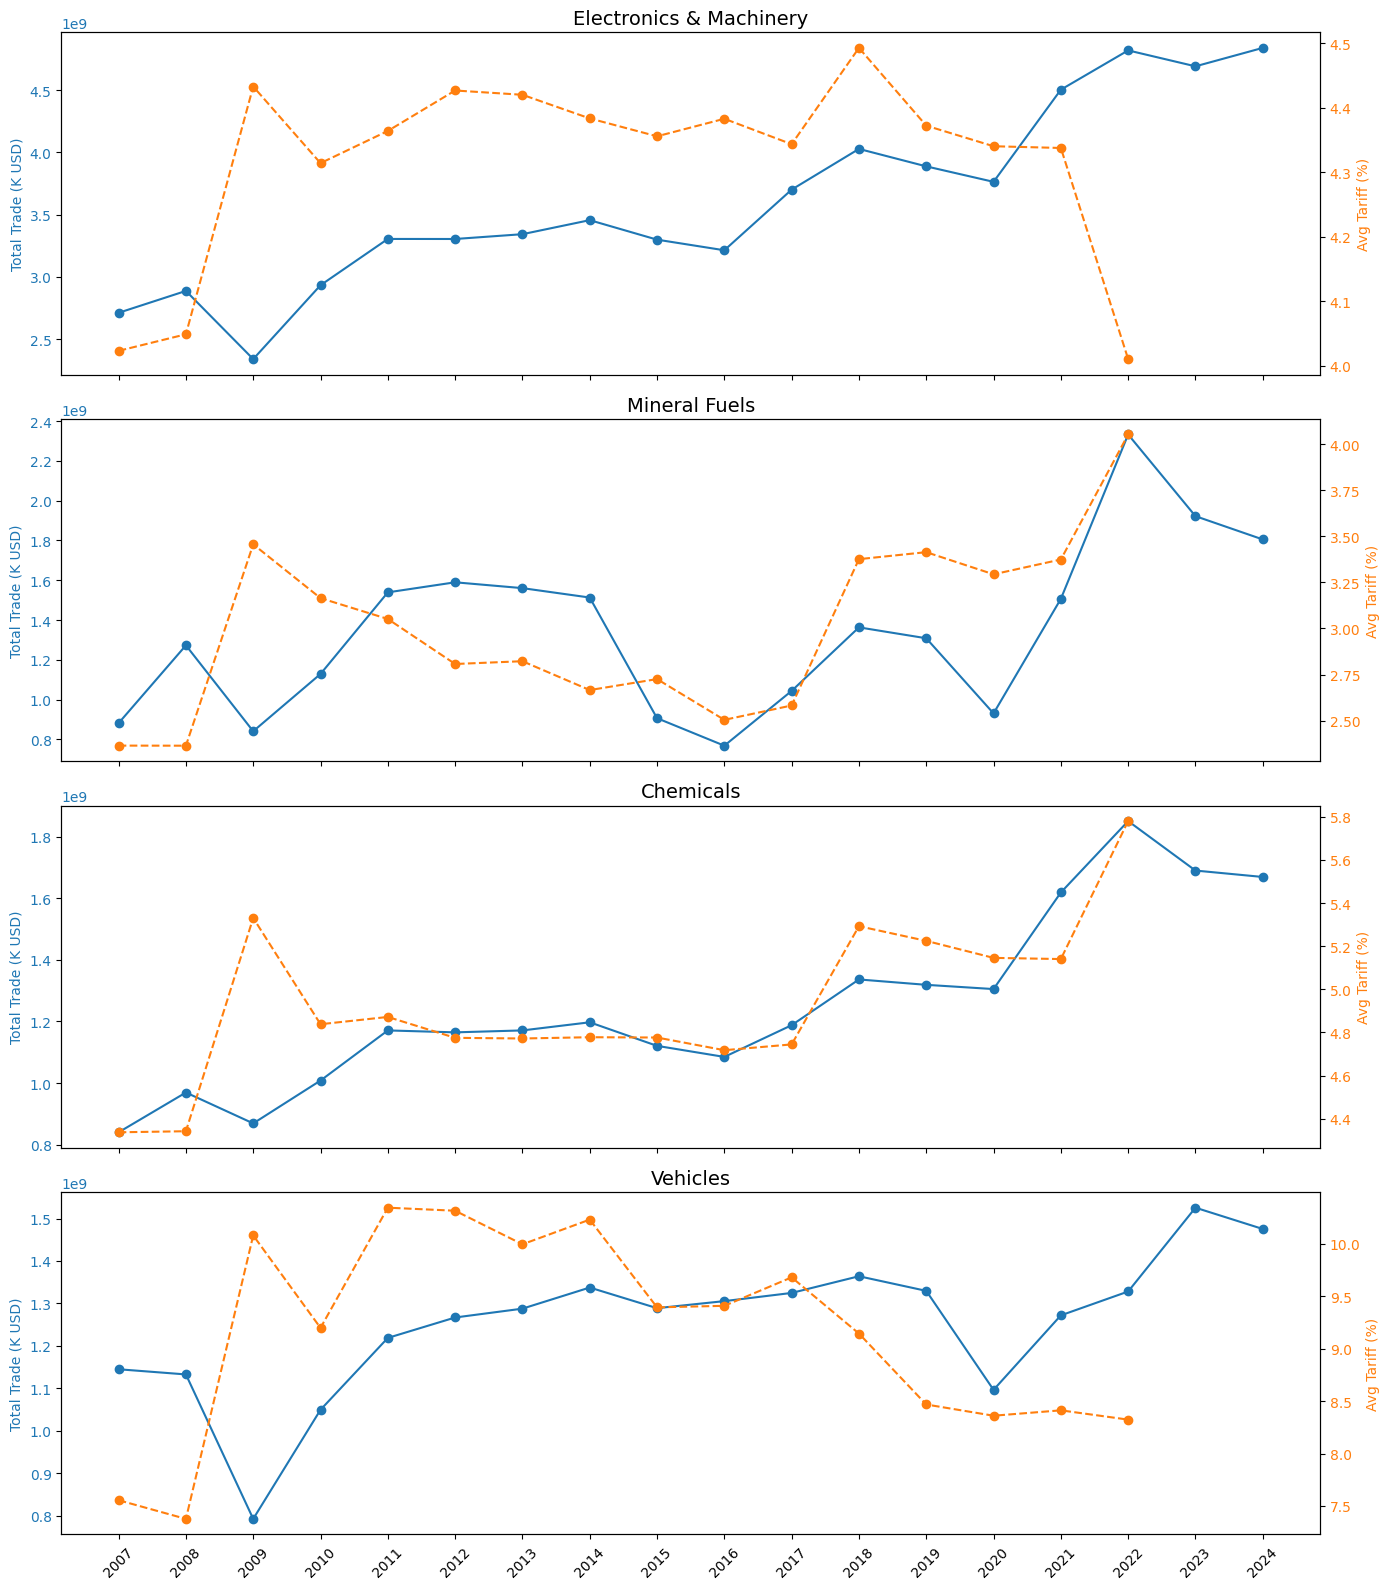

In [23]:
# Convert Spark DF → Pandas
pdf = df_final.select("Year", "Sector", "TradeValueKUSD", "EffectiveTariff") \
              .groupBy("Year", "Sector") \
              .agg(
                  F.sum("TradeValueKUSD").alias("TotalTrade"),
                  F.avg("EffectiveTariff").alias("AvgTariff")
              ) \
              .orderBy("Year") \
              .toPandas()

# Choose the sectors we want to visualize
top_sectors = ["Electronics & Machinery", "Mineral Fuels", "Chemicals", "Vehicles"]

# Filter for selected sectors
plot_df = pdf[pdf["Sector"].isin(top_sectors)]

# Create vertical subplots
fig, axes = plt.subplots(len(top_sectors), 1, figsize=(14, 16), sharex=True)

for i, sector in enumerate(top_sectors):
    ax1 = axes[i]
    sec_df = plot_df[plot_df["Sector"] == sector]

    # Plot trade (left axis)
    ax1.plot(sec_df["Year"], sec_df["TotalTrade"], marker="o", label="Trade Value (K USD)", color="#1f77b4")
    ax1.set_ylabel("Total Trade (K USD)", color="#1f77b4")
    ax1.tick_params(axis='y', labelcolor="#1f77b4")

    # Second axis for tariff
    ax2 = ax1.twinx()
    ax2.plot(sec_df["Year"], sec_df["AvgTariff"], linestyle="--", marker="o",
             label="Avg Tariff (%)", color="#ff7f0e")
    ax2.set_ylabel("Avg Tariff (%)", color="#ff7f0e")
    ax2.tick_params(axis='y', labelcolor="#ff7f0e")

    # Title
    ax1.set_title(f"{sector}", fontsize=14)

    # Fix x-axis (every year visible)
    ax1.set_xticks(sorted(sec_df["Year"].unique()))
    ax1.set_xticklabels(sorted(sec_df["Year"].unique()), rotation=45)

plt.tight_layout()
plt.show()


Across all four sectors, both trade values and tariff rates show noticeable fluctuations over time, but their movements rarely align — suggesting that tariff changes alone do not drive major shifts in trade. In Electronics & Machinery, tariffs move between ~4.0% and ~4.5%, with visible short-term fluctuations, yet trade continues its long-term upward trend except for dips around 2009 and 2015–2016. These trade drops do not correspond to tariff spikes, indicating that external macroeconomic events (global financial crisis, manufacturing slowdown) mattered more than tariff policy.

In Mineral Fuels, tariffs fluctuate moderately (2.5–4.0%), including a spike around 2010, but trade moves largely independently — falling during global oil price collapses and surging around 2022 due to global energy disruptions. This sector shows the clearest example where tariff swings do not predict trade swings.

In Chemicals, tariffs rise and fall across the range of ~4.4%–5.8%, but trade largely follows its own path, with a significant increase after 2020 despite a drop in tariffs — showing that demand recovery and industry expansion drove trade more than tariff adjustments.

Vehicles shows the largest tariff volatility (7.5%–10.5%). Yet trade continues a mostly upward trajectory and even spikes in 2023, despite tariffs trending downward. The trade dip around 2019–2020 aligns more with global supply-chain disruption than tariff changes.

Overall, although tariffs do fluctuate meaningfully in all sectors, the timing and direction of tariff movements do not consistently correlate with trade movements. Major trade spikes/dips align more closely with global shocks — financial crisis, commodity cycles, COVID recovery, energy disruption — rather than tariff variations. This suggests that key export sectors are partially insulated from tariff volatility and that tariff shifts create weak or delayed ripple effects rather than immediate trade responses.

**Summary**
Our analysis shows that tariff effects are highly sector-specific rather than universal.

* Sectors NOT sensitive to tariffs (positive correlation)

    Agriculture, Mineral Fuels, Chemicals, Minerals, and Art & Antiques continue trading strongly even when tariffs are high.
    These are essential or demand-driven goods, so tariffs do not significantly reduce trade.

* Sectors sensitive to tariffs (negative correlation)

    Plastics & Rubber, Misc. Manufacturing, Electronics & Machinery, Footwear, Textiles, and Vehicles show reduced trade when tariffs rise.
    These industries are price-elastic and globally competitive, so tariffs directly affect trade volumes.

* Year-to-year tariff changes intensify reactions

    Manufactured sectors (Vehicles, Electronics, Metals, Footwear) show strong negative responses to even small tariff changes.
    These sectors adjust quickly to policy shifts, making them more “disruption-prone.”

**Overall Insight**

* Tariffs do not impact all industries equally.

* Commodities remain stable despite tariff levels or changes.

* Manufactured goods are highly sensitive, and their trade drops when tariffs increase.

This sector-specific behavior is crucial for understanding how tariff shocks ripple through global commerce and should guide the rest of our project analysis.